In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense,InputLayer,Embedding,Conv1D,MaxPooling1D,Input,LSTM,BatchNormalization,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping,Callback
import re
import time

In [2]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load and read data
#https://datascienceparichay.com/article/python-split-string-by-newline-character/#:~:text=You%20can%20use%20the%20Python,to%20the%20split()%20function.
lines=open("/content/drive/MyDrive/movie_lines.txt",encoding="utf-8",errors="ignore").read().split('\n')
Conversations=open("/content/drive/MyDrive/movie_conversations.txt",encoding="utf-8",errors="ignore").read().split('\n')
Conversations
print(type(lines))
print(lines[0])
print("*"*50)
print(Conversations[0])

<class 'list'>
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
**************************************************
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']


In [4]:
#create dictonary that map each line to ids
linetoides={}
for k in lines:
  line=k.split('+++$+++')  #we will get  e.g. ['L1045 ', ' u0 ', ' m0 ', ' BIANCA ', ' They do not!']
  linetoides[line[0].replace(" ",'')]=line[-1]

In [5]:
#creating list of allconversation 
Conversation_ids=[]
for Conversation  in Conversations:
    _Conversation=Conversation.split('+++$+++')[-1][3:-1].replace("'",'').replace(" ",'')
    Conversation_ids.append(_Conversation.split(","))

In [ ]:
Conversation_ids[0]

In [6]:
#Seprate Question and answer
#['L194', 'L195', 'L196', 'L197'] here firt element L194 will be question and 2nd L195 will be answer  same like 'L196' is quesion and 'L197' is answer
question=[]
answer=[]

for res in Conversation_ids:
  for k in range(len(res)-1):
    question.append(linetoides[res[k]])
    answer.append(linetoides[res[k+1]])
   

In [ ]:
print(question[2],answer[2])

###Preprocessing for Seq2Seq

Please put this information on your mind, let’s start to talk about preprocessing. The whole process could be broken down into 8steps:

1. Text Cleaning
2. Make Vocabulary (VOCAB_SIZE)
3. Split Data for training and validation, testing
4. Create Encoder_input,Decoder _input with '<start.>' and Decoder_output with <end.>
5. Tokenize Bag of words to Bag of IDs
6. Padding (MAX_LEN)
7. Word Embedding (EMBEDDING_DIM)
8. Reshape the Data depends on neural network shape



###1. Text Cleaning 

In [7]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [8]:
def decontracted(text):
    '''this function will Replace all apostrophe/short words from text data'''
    for word in text.split():
        if word.lower() in CONTRACTION_MAP:
            text = text.replace(word, CONTRACTION_MAP[word.lower()])
    return text

In [9]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text=text.lower()
    text = re.sub(r'\.+', ".", text) #Replace multiple fullstops with single fullstop

    text = re.sub(r"[^a-zA-Z?.!,']+", " ", text)# replacing everything with space except (a-z, ".", "?", "!", ",", "'")

    # Compact spaces
    text = re.sub(r'[" "]+', " ", text)

    final_text = text.strip()
    
    return text

In [10]:
from tqdm import tqdm
Clean_question=[] #Clean question
for text in tqdm(question):
  Clean_question.append(clean_text(text))

Clean_answer=[] #Clean ansewer
for texts in tqdm(answer):
  Clean_answer.append(clean_text(texts))

100%|██████████| 221616/221616 [00:06<00:00, 33286.68it/s]


In [ ]:
print(Clean_question[2],Clean_answer[2])

 not the hacking and gagging and spitting part. please.  okay. then how about we try out some french cuisine. saturday? night?


###3. Create Encoder_input,Decoder _input with '<start.>' and Decoder_output with <end.>


In [ ]:
Clean_question[:6]

[' can we make this quick? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad. again.',
 ' well, i thought we would start with pronunciation, if that is okay with you.',
 ' not the hacking and gagging and spitting part. please.',
 ' you are asking me out. that is so cute. that is your name again?',
 ' no, no, it is my fault we did not have a proper introduction ',
 ' cameron.']

In [11]:
#<Start> means "Begin of Sequence", <END> means "End of Sequence".
#Encoder_input=Clean_question
def Decoder_input_tagg(decoder_input_sentence):
  start = "<start> "
  Decoder_input = [start + text  for text in decoder_input_sentence] 
  return Decoder_input

def Decoder_Target_tagg(decoder_Target_sentence):
  END = " <end>"
  Decoder_target = [ text+END  for text in decoder_Target_sentence] 
  return Decoder_target

def encoder_input(encoder_inp):
    start = "<start> "
    end=" <end>"
    Decoder_input = [start + text + end for text in encoder_inp] 
    return Decoder_input
    

Decoder_inputs = Decoder_input_tagg(Clean_answer)
Decoder_target = Decoder_Target_tagg(Clean_answer)
Encoder_input = encoder_input(Clean_question)

In [ ]:
Encoder_input[:2]

['<start>  can we make this quick? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad. again. <end>',
 '<start>  well, i thought we would start with pronunciation, if that is okay with you. <end>']

In [12]:
df = pd.DataFrame(list(zip(Encoder_input, Decoder_inputs,Decoder_target)), columns =['Encoder_input', 'Decoder_inputs','Decoder_output']) 
df.head(10)

,Encoder_input,Decoder_inputs,Decoder_output
0,<start> can we make this quick? roxanne korri...,"<start> well, i thought we would start with p...","well, i thought we would start with pronuncia..."
1,"<start> well, i thought we would start with p...",<start> not the hacking and gagging and spitt...,not the hacking and gagging and spitting part...
2,<start> not the hacking and gagging and spitt...,<start> okay. then how about we try out some ...,okay. then how about we try out some french c...
3,<start> you are asking me out. that is so cut...,<start> forget it.,forget it. <end>
4,"<start> no, no, it is my fault we did not hav...",<start> cameron.,cameron. <end>
5,<start> cameron. <end>,"<start> the thing is, cameron i am at the mer...","the thing is, cameron i am at the mercy of a ..."
6,"<start> the thing is, cameron i am at the mer...",<start> seems like she could get a date easy ...,seems like she could get a date easy enough. ...
7,<start> why? <end>,<start> unsolved mystery. she used to be real...,unsolved mystery. she used to be really popul...
8,<start> unsolved mystery. she used to be real...,<start> that is a shame.,that is a shame. <end>
9,"<start> gosh, if only we could find kat a boy...",<start> let me see what i can do.,let me see what i can do. <end>


In [ ]:
df.shape

(221616, 3)

In [13]:
%%time
df['Encoder_input'] = df.apply(lambda x: decontracted(x["Encoder_input"]),axis=1)
df['Decoder_inputs'] = df.apply(lambda x: decontracted(x["Decoder_inputs"]),axis=1)
df['Decoder_output'] = df.apply(lambda x: decontracted(x["Decoder_output"]),axis=1)

CPU times: user 7.18 s, sys: 33 ms, total: 7.22 s
Wall time: 7.23 s


In [15]:
df.drop_duplicates(subset = ["Encoder_input","Decoder_inputs","Decoder_output"],inplace=True)

In [16]:
df.shape

(219737, 3)

In [17]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,test_size=0.15,random_state=12)

In [19]:
print("train dataset size {}".format(train.shape))
print("test dataset size {}".format(test.shape))

train dataset size (186776, 3)
test dataset size (32961, 3)


###Created function to tokenize the train and test data


In [28]:
def tokenization(x_train,x_test):
    '''this functon will take input both train and test data and tokenize them'''
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(x_train)
    x_train = tokenizer.texts_to_sequences(x_train)
    x_test = tokenizer.texts_to_sequences(x_test)
    
    x_train = pad_sequences(x_train, padding='post',maxlen=15)
    x_test = pad_sequences(x_test, padding='post',maxlen=15)
    return tokenizer,x_train,x_test

In [21]:
Enc_Tokenizer,train_Encoder_input,test_Encoder_input=tokenization(train["Encoder_input"],test["Encoder_input"])
Dec_Tokenizer,train_Decoder_input,test_Decoder_input=tokenization(train["Decoder_inputs"],test["Decoder_inputs"])
Dec_Tokenizer_target,train_Decoder_output,test_Decoder_output=tokenization(train["Decoder_output"],test["Decoder_output"])

In [29]:
input_vocab=len(Enc_Tokenizer.word_index)+1
output_vocab=len(Dec_Tokenizer_target.word_index)+1
print("input vocab length {}".format(input_vocab))
print("output vocab length {}".format(output_vocab))

input vocab length 85576
output vocab length 85596


In [30]:
print("train data Encoder input length {}".format(train_Encoder_input.shape[1]))
print("train data Deccoder input length {}".format(train_Decoder_input.shape[1]))
print("train data Deccoder output length {}".format(train_Decoder_output.shape[1]))

train data Encoder input length 15
train data Deccoder input length 15
train data Deccoder output length 15


In [24]:
print("test data Encoder input length {}".format(test_Encoder_input.shape[1]))
print("test data Deccoder input length {}".format(test_Decoder_input.shape[1]))
print("test data Deccoder output length {}".format(test_Decoder_output.shape[1]))

test data Encoder input length 15
test data Deccoder input length 15
test data Deccoder output length 15


In [31]:
#To decode the sentences we will need to create the reverse features dictionary that stores index as a key and word as a value.
# Creating the dictiionary with output vocab words Reverse
target_token_index=Dec_Tokenizer_target.word_index
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [32]:
reverse_target_char_index[2]

'i'

###Model-Bidirectional LSTM Encoder layer

In [33]:
# defining some vairable like embedding size , number of gru or lstm units batch size and epochs we are going to run to train the model
embedding_dim=100    
latent_dim= 100      
batch_size=128      
epochs = 15

In [34]:
# Bidirectional LSTM Encoder layer
encoder_in_layer = tf.keras.layers.Input(shape=(train_Encoder_input.shape[1],))

encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab, output_dim=embedding_dim)

encoder_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=latent_dim, return_sequences=True, return_state=True))

# Discard the encoder output and use hidden states (h) and cell stata(c) both forward and backward
encoder_out,fstate_h,fstate_c, bstate_h,bstate_c= encoder_bi_lstm(encoder_embedding(encoder_in_layer))

state_h = tf.keras.layers.Concatenate()([fstate_h,bstate_h])
state_c = tf.keras.layers.Concatenate()([fstate_c,bstate_c])
Final_encoder_states = [state_h, state_c]


# LTSM Decoder layer
decoder_in_layer = tf.keras.layers.Input(shape=(None,))

decoder_embedding = tf.keras.layers.Embedding(input_dim=100, output_dim=embedding_dim)

decoder_lstm = tf.keras.layers.LSTM(units=latent_dim*2, return_sequences=True, return_state=True)

# Discard internal states in training, keep only the output sequence
decoder_out, _,_ = decoder_lstm(decoder_embedding(decoder_in_layer), initial_state=Final_encoder_states)

decoder_dense = tf.keras.layers.Dense(output_vocab, activation="softmax")

decoder_out_layer = decoder_dense(decoder_out)

# Define the model that uses the Encoder and the Decoder
model = tf.keras.models.Model([encoder_in_layer, decoder_in_layer], decoder_out_layer)

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 100)      8557600     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 15, 200),    160800      ['embedding[0][0]']              
                                 (None, 100),                                                 

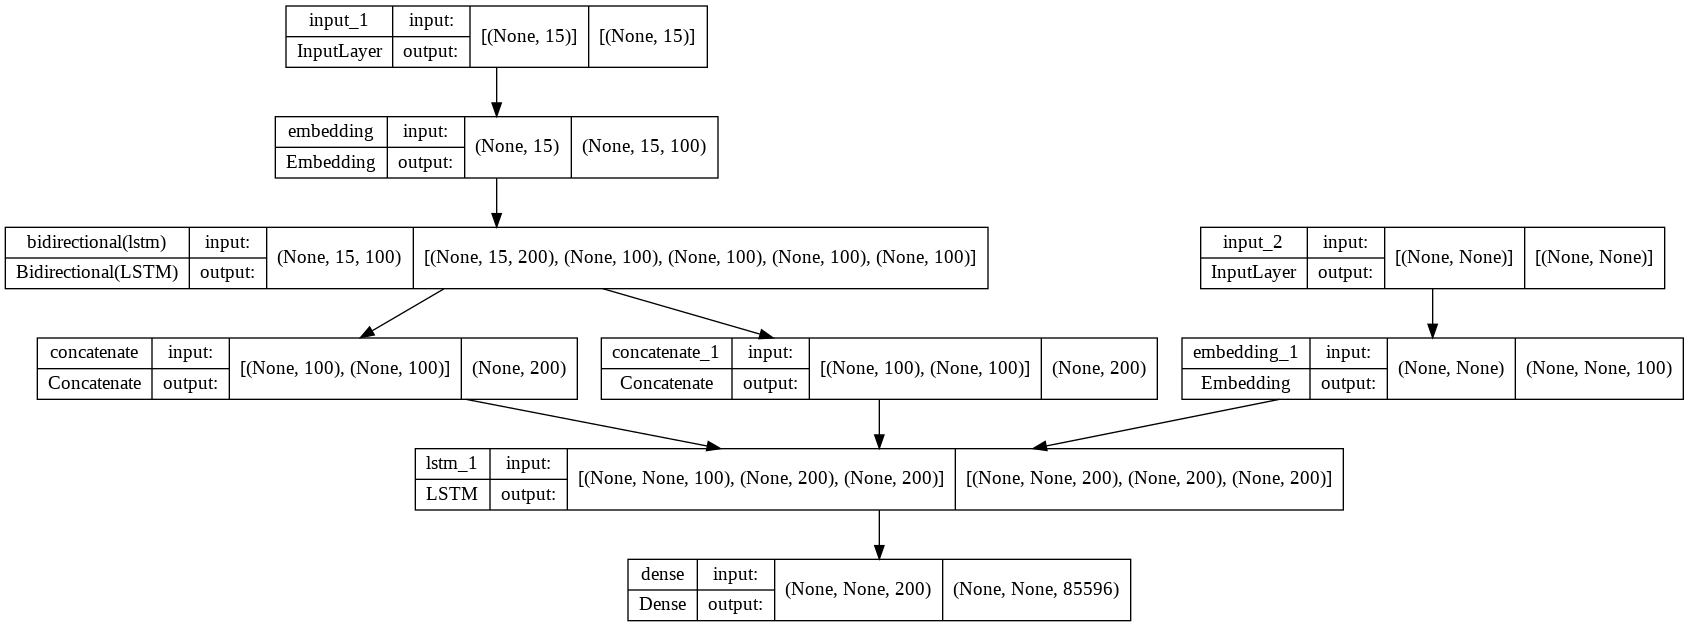

In [36]:
# summarize the model
from tensorflow.keras.utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

In [37]:
history2 = model.fit([train_Encoder_input, train_Decoder_input], train_Decoder_output,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=([test_Encoder_input,test_Decoder_input],test_Decoder_output))

Epoch 1/18
1460/1460 [==============================] - 199s 130ms/step - loss: 3.8899 - val_loss: 3.3223
Epoch 2/18
1460/1460 [==============================] - 194s 133ms/step - loss: 3.3385 - val_loss: 3.1978
Epoch 3/18
1460/1460 [==============================] - 194s 133ms/step - loss: 3.2166 - val_loss: 3.1480
Epoch 4/18
1460/1460 [==============================] - 194s 133ms/step - loss: 3.1329 - val_loss: 3.1273
Epoch 5/18
1460/1460 [==============================] - 194s 133ms/step - loss: 3.0625 - val_loss: 3.1237
Epoch 6/18
1460/1460 [==============================] - 194s 133ms/step - loss: 2.9984 - val_loss: 3.1303
Epoch 7/18
1460/1460 [==============================] - 194s 133ms/step - loss: 2.9384 - val_loss: 3.1477
Epoch 8/18
1460/1460 [==============================] - 194s 133ms/step - loss: 2.8808 - val_loss: 3.1713
Epoch 9/18
1460/1460 [==============================] - 195s 133ms/step - loss: 2.8255 - val_loss: 3.1958
Epoch 10/18
1460/1460 [=======================

In [38]:
# Inference Decoder
encoder_model = tf.keras.models.Model(encoder_in_layer, Final_encoder_states)

state_input_h = tf.keras.layers.Input(shape=(latent_dim*2,))
state_input_c = tf.keras.layers.Input(shape=(latent_dim*2,))
state_input = [state_input_h, state_input_c]
decoder_out, decoder_h,decoder_c = decoder_lstm(decoder_embedding(decoder_in_layer), initial_state=state_input)
decoder_states2 = [decoder_h, decoder_c]
decoder_out = decoder_dense(decoder_out)
decoder_model = tf.keras.models.Model(inputs=[decoder_in_layer, state_input], 
                  outputs=[decoder_out,decoder_states2])

In [39]:
def decode_sequence2(input_seq):
    '''this function will predict the next words sequences given the input sequences'''
    if input_seq.split(' ')[0] != '<start>' and input_seq.split(' ')[-1] != '<end>':
        input_seq = '<start>'+ ' ' + input_seq + ' ' + '<end>'
    
    #print("input seq",input_seq)
    input_seq = Enc_Tokenizer.texts_to_sequences([str(input_seq)])
    input_seq = pad_sequences(input_seq, padding="post",maxlen= 15)
    
     # Encode the input as state vectors.
    state = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = Dec_Tokenizer.word_index['<start>']
    
    # Encode the input as state vectors.
    curr_word = "<start>"
    decoded_sentence = ''

    i = 0
    while curr_word != "<end>" and i < (15 - 1):
        output_tokens, h = decoder_model.predict([target_seq, state])

        curr_token = np.argmax(output_tokens[0, 0])

        if (curr_token == 0):
            break;

        curr_word = reverse_target_char_index[curr_token]

        decoded_sentence += ' ' + curr_word
        target_seq[0, 0] = curr_token
        state = h
        i += 1
    if curr_word != "<end>":
        decoded_sentence += ' ' + '<end>'
    return decoded_sentence

In [44]:
sample = df.sample(10)

In [45]:
for i in range(10):
    print('Input ---->' , sample["Encoder_input"].iloc[i])
    print('Output ---->' , sample["Decoder_inputs"].iloc[i])
    print('Predict ---->', decode_sequence2(sample["Encoder_input"].iloc[i]))
    print('=='*50)

Input ----> <start>  she is dead is not she? <end>
Output ----> <start>  yes.
Predict ---->  she is a good man. <end>
Input ----> <start>  sorry. we were saying? <end>
Output ----> <start>  you broke that idiot's jaw for no reason other than your boredom. tell the truth, roland. are not you even interested in knowing this expeditiongs quarry?
Predict ---->  i am not a traitor. <end>
Input ----> <start>  that was a mistake. the rain on my car is a baptism. the new me. iceman, power lloyd. my assault on the world begins now. believe in myself, answer to no one. you probably got it all figured out, corey. if you start out depressed, everything's kind of a pleasant surprise. <end>
Output ----> <start>  look, why do not you just call diane again?
Predict ---->  but i am not sure of a bitch. watcher. huh <end>
Input ----> <start>  i believe we are being called to dinner. <end>
Output ----> <start>  finally!
Predict ---->  what do you mean? <end>
Input ----> <start>  red rum. <end>
Output ---